In [1]:
from utils import (PaintingsDataset,Unet_Discriminator, Unet_Discriminator_V2, Unet_Generator_V2, unet_d_criterion_without_cutmix_v2)
import random
from torchvision import transforms
import torchvision.transforms as transforms
import torch
import torch.optim as optim
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

c:\Users\Mrabe\miniconda3\envs\dyjest\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


<strong> Building the dataset </strong>

In [2]:
# Building the dataset

image_dir = '../../data/pixel_art/images/images/'

transform = transforms.Compose([
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])



images = PaintingsDataset(image_dir, transform)

<strong> Sampling an image from the dataset </strong>

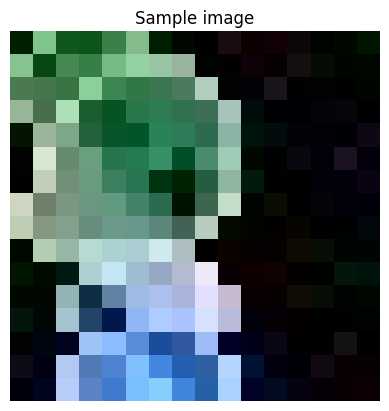

In [3]:
# Plotting an example from  the dataset
n = len(images)
integer = random.randint(0,n)
image = images[integer].numpy()*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample image')
plt.show()


<strong> Building the dataloader </strong>

In [4]:
dataloader = DataLoader(images, batch_size=256)

<strong> Building the models </strong>

In [5]:
latent_dim = 40
channels_out = 3
input_channels = 3
n_classes = 2

D_unet = Unet_Discriminator_V2(input_channels, n_classes)
G_unet = Unet_Generator_V2(latent_dim, channels_out)

<strong> Generating an image before training the generator </strong>

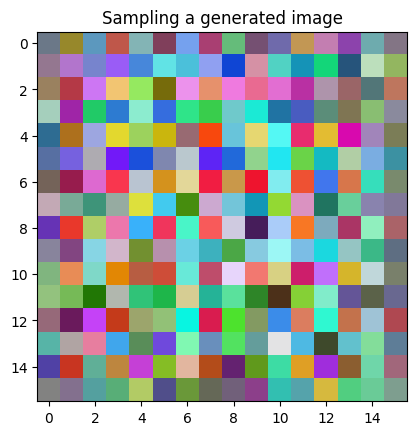

In [6]:
noise_image = D_unet(images[0].unsqueeze(0))[1][0]

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G_unet(noise)

# Plotting the image 
image_noise = fake_images.detach().numpy().reshape((3,16,16))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

<strong> Training loop</strong>

In [10]:
torch.autograd.set_detect_anomaly(True)

input_channels = 3
n_classes = 2
k = 1 # Steps to train generator
latent_dim = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device) 

G_unet = G_unet.to(device)
D_unet = D_unet.to(device)

criterion = unet_d_criterion_without_cutmix_v2

optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_d_unet = optim.Adam(D_unet.parameters(), lr=5e-4, betas=(0.5, 0.999)) 

D_loss, G_loss = [], []

epochs = 1000
epoch_eval = epochs // 10

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500
N = len(images)
indices = random.sample(range(N), n_samples)

real_images_eval = torch.stack([images[idx] for idx in indices])
fid.update(real_images_eval, real=True)

FID_values = []

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Get real images
        real_images = batch.to(device)  # Move batch to GPU
        batch_size = real_images.size(0)
        labels_1 = torch.ones(batch_size, 1, device=device)  # Real labels on GPU
        labels_2 = torch.ones(batch_size, 1, device=device)

        # Train discriminator with real images
        D_unet.zero_grad()
        output = D_unet(real_images)
        loss_d_real = criterion(output, labels_1, batch_size)

        # Train discriminator with fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # Generate noise on GPU
        fake_images = G_unet(noise)
        labels_2.fill_(0)  # Fake labels
        output = D_unet(fake_images.detach())
        loss_d_fake = criterion(output, labels_2, batch_size)
        
        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()
        optimizer_d_unet.step()

        if epoch % k == 0:
            # Train generator
            labels_3 = torch.ones(batch_size, 1, device=device)
            G_unet.zero_grad()
            labels_3.fill_(1)  # Real labels
            output = D_unet(fake_images)
            loss_g = criterion(output, labels_3, batch_size)
            loss_g.backward()
            optimizer_g_unet.step()

    if epoch % epoch_eval == 0:
        # Eval mode
        G_unet_eval = G_unet.eval()
        # Generating fake images
        noise = torch.randn(n_samples, latent_dim, 1, 1, device=device)
        fake_images_eval = G_unet_eval(noise).to(torch.device('cpu'))
        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)
        # Storing loss values
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())
        # Train mode
        G_unet.train()

            
    
    end_time = time.time()
    if epoch % k == 0:

        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
    
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')
    
    print(f'Epoch {epoch +1} duration :   {end_time - start_time}')

cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [0/1000] | Loss D: 110.86632537841797 | Loss G: 319.31109619140625
Epoch 1 duration :   2.602747678756714


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/1000] | Loss D: 2231.29248046875 | Loss G: 569.2075805664062
Epoch 2 duration :   15.375083446502686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/1000] | Loss D: 194.3316650390625 | Loss G: 500.4755859375
Epoch 3 duration :   16.32791519165039


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/1000] | Loss D: 115.75946044921875 | Loss G: 1032.2061767578125
Epoch 4 duration :   16.70902109146118


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/1000] | Loss D: 83.73361206054688 | Loss G: 1253.7252197265625
Epoch 5 duration :   14.841025114059448


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/1000] | Loss D: 139.873046875 | Loss G: 871.99072265625
Epoch 6 duration :   14.349569082260132


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/1000] | Loss D: 107.70882415771484 | Loss G: 664.0086669921875
Epoch 7 duration :   15.651609182357788


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/1000] | Loss D: 21.801231384277344 | Loss G: 1269.7943115234375
Epoch 8 duration :   14.955559968948364


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/1000] | Loss D: 601.032470703125 | Loss G: 34.700469970703125
Epoch 9 duration :   15.417834281921387


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/1000] | Loss D: 191.18557739257812 | Loss G: 419.8024597167969
Epoch 10 duration :   15.236807107925415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/1000] | Loss D: 156.1670379638672 | Loss G: 542.8215942382812
Epoch 11 duration :   15.926182985305786


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/1000] | Loss D: 98.855712890625 | Loss G: 755.2550048828125
Epoch 12 duration :   15.81580662727356


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/1000] | Loss D: 50.06648254394531 | Loss G: 1062.3941650390625
Epoch 13 duration :   15.844907283782959


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/1000] | Loss D: 22.40238380432129 | Loss G: 1411.932861328125
Epoch 14 duration :   15.80766749382019


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/1000] | Loss D: 13.136996269226074 | Loss G: 1538.7904052734375
Epoch 15 duration :   16.431277990341187


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/1000] | Loss D: 6.4994001388549805 | Loss G: 1676.5242919921875
Epoch 16 duration :   15.484997272491455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/1000] | Loss D: 6.111649990081787 | Loss G: 1646.0867919921875
Epoch 17 duration :   15.359714984893799


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/1000] | Loss D: 9.953405380249023 | Loss G: 1673.2203369140625
Epoch 18 duration :   15.301104068756104


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/1000] | Loss D: 6.651064872741699 | Loss G: 4111.666015625
Epoch 19 duration :   15.419546365737915


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/1000] | Loss D: 7.7508392333984375 | Loss G: 1986.6842041015625
Epoch 20 duration :   15.087110757827759


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/1000] | Loss D: 8.740070343017578 | Loss G: 1795.22900390625
Epoch 21 duration :   15.229954242706299


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/1000] | Loss D: 1.8717715740203857 | Loss G: 4946.81640625
Epoch 22 duration :   15.170216798782349


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/1000] | Loss D: 0.6842601895332336 | Loss G: 4164.779296875
Epoch 23 duration :   15.508274793624878


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/1000] | Loss D: 1.1141283512115479 | Loss G: 4832.296875
Epoch 24 duration :   15.392244577407837


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/1000] | Loss D: 38.435367584228516 | Loss G: 2131.123046875
Epoch 25 duration :   15.783991575241089


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/1000] | Loss D: 2.3940296173095703 | Loss G: 3036.165771484375
Epoch 26 duration :   15.343838691711426


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/1000] | Loss D: 3.136837959289551 | Loss G: 2240.30419921875
Epoch 27 duration :   15.772884368896484


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/1000] | Loss D: 1.1694098711013794 | Loss G: 3865.3466796875
Epoch 28 duration :   15.581567764282227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/1000] | Loss D: 2.70231032371521 | Loss G: 3364.424072265625
Epoch 29 duration :   15.177443027496338


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/1000] | Loss D: 9.862274169921875 | Loss G: 4665.16650390625
Epoch 30 duration :   15.391921043395996


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/1000] | Loss D: 2.7100489139556885 | Loss G: 3566.011474609375
Epoch 31 duration :   15.8521888256073


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/1000] | Loss D: 7.265563011169434 | Loss G: 3709.485595703125
Epoch 32 duration :   15.298372745513916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/1000] | Loss D: 2.827042579650879 | Loss G: 3368.7392578125
Epoch 33 duration :   15.634422779083252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/1000] | Loss D: 8.576273918151855 | Loss G: 3953.66064453125
Epoch 34 duration :   15.240347862243652


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/1000] | Loss D: 8.977136611938477 | Loss G: 4743.0556640625
Epoch 35 duration :   15.624769687652588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/1000] | Loss D: 262.01104736328125 | Loss G: 177.78411865234375
Epoch 36 duration :   15.55464792251587


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/1000] | Loss D: 208.54310607910156 | Loss G: 242.301513671875
Epoch 37 duration :   15.381495237350464


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/1000] | Loss D: 157.46192932128906 | Loss G: 241.11572265625
Epoch 38 duration :   15.614372730255127


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/1000] | Loss D: 106.60391235351562 | Loss G: 360.80657958984375
Epoch 39 duration :   15.519752264022827


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/1000] | Loss D: 62.93448257446289 | Loss G: 684.8758544921875
Epoch 40 duration :   15.463364362716675


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/1000] | Loss D: 1129.3343505859375 | Loss G: 770.0802001953125
Epoch 41 duration :   15.29637861251831


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/1000] | Loss D: 152.12396240234375 | Loss G: 2698.673583984375
Epoch 42 duration :   15.585984468460083


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/1000] | Loss D: 32.79840087890625 | Loss G: 3478.919921875
Epoch 43 duration :   15.410690307617188


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/1000] | Loss D: 4.568864822387695 | Loss G: 3309.360595703125
Epoch 44 duration :   15.744148015975952


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/1000] | Loss D: 2.6849241256713867 | Loss G: 3163.614990234375
Epoch 45 duration :   15.635579586029053


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/1000] | Loss D: 2.4348270893096924 | Loss G: 3072.97998046875
Epoch 46 duration :   15.504728555679321


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/1000] | Loss D: 2.3184573650360107 | Loss G: 3061.134765625
Epoch 47 duration :   15.780060529708862


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/1000] | Loss D: 2.1034958362579346 | Loss G: 3185.5
Epoch 48 duration :   15.813445091247559


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/1000] | Loss D: 21.173377990722656 | Loss G: 3767.612548828125
Epoch 49 duration :   15.503586769104004


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/1000] | Loss D: 272.83843994140625 | Loss G: 228.3996124267578
Epoch 50 duration :   16.011468410491943


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/1000] | Loss D: 270.2432556152344 | Loss G: 222.96112060546875
Epoch 51 duration :   15.605814695358276


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51/1000] | Loss D: 247.70901489257812 | Loss G: 231.91891479492188
Epoch 52 duration :   15.306909561157227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52/1000] | Loss D: 139.84033203125 | Loss G: 271.57794189453125
Epoch 53 duration :   15.478482961654663


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53/1000] | Loss D: 106.05892181396484 | Loss G: 331.7856140136719
Epoch 54 duration :   16.007769107818604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54/1000] | Loss D: 78.35881805419922 | Loss G: 403.7233581542969
Epoch 55 duration :   15.656410217285156


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55/1000] | Loss D: 63.37031936645508 | Loss G: 485.17144775390625
Epoch 56 duration :   15.619918584823608


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56/1000] | Loss D: 44.202430725097656 | Loss G: 559.338623046875
Epoch 57 duration :   15.514777183532715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57/1000] | Loss D: 25610.28515625 | Loss G: 0.0005812125164084136
Epoch 58 duration :   15.64691710472107


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58/1000] | Loss D: 25603.88671875 | Loss G: 0.5124988555908203
Epoch 59 duration :   15.787097454071045


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59/1000] | Loss D: 25600.869140625 | Loss G: 1.0038765668869019
Epoch 60 duration :   15.515859365463257


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [60/1000] | Loss D: 25600.671875 | Loss G: 1.118565559387207
Epoch 61 duration :   15.499979257583618


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [61/1000] | Loss D: 25600.490234375 | Loss G: 1.4083372354507446
Epoch 62 duration :   15.662818193435669


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [62/1000] | Loss D: 25600.3515625 | Loss G: 1.8558796644210815
Epoch 63 duration :   15.475350856781006


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [63/1000] | Loss D: 25600.2421875 | Loss G: 2.311436414718628
Epoch 64 duration :   15.89278793334961


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [64/1000] | Loss D: 25600.171875 | Loss G: 2.6342215538024902
Epoch 65 duration :   15.601583480834961


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [65/1000] | Loss D: 25600.14453125 | Loss G: 2.926723003387451
Epoch 66 duration :   15.633514642715454


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [66/1000] | Loss D: 25600.126953125 | Loss G: 3.1477279663085938
Epoch 67 duration :   15.770925521850586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [67/1000] | Loss D: 25600.099609375 | Loss G: 3.304957866668701
Epoch 68 duration :   16.36829447746277


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [68/1000] | Loss D: 25600.080078125 | Loss G: 3.5645289421081543
Epoch 69 duration :   15.836849212646484


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [69/1000] | Loss D: 25600.078125 | Loss G: 3.6872873306274414
Epoch 70 duration :   15.53429365158081


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [70/1000] | Loss D: 25600.064453125 | Loss G: 3.808458089828491
Epoch 71 duration :   15.589162826538086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [71/1000] | Loss D: 25600.07421875 | Loss G: 3.9416909217834473
Epoch 72 duration :   15.568418264389038


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [72/1000] | Loss D: 25600.068359375 | Loss G: 3.9647467136383057
Epoch 73 duration :   15.599826097488403


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [73/1000] | Loss D: 25600.052734375 | Loss G: 4.071381092071533
Epoch 74 duration :   15.80189323425293


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [74/1000] | Loss D: 25600.0703125 | Loss G: 4.226587772369385
Epoch 75 duration :   15.501966714859009


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [75/1000] | Loss D: 25600.044921875 | Loss G: 4.261064052581787
Epoch 76 duration :   15.581013917922974


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [76/1000] | Loss D: 25600.044921875 | Loss G: 4.331515789031982
Epoch 77 duration :   15.614391803741455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [77/1000] | Loss D: 25600.046875 | Loss G: 4.446595191955566
Epoch 78 duration :   15.589155673980713


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [78/1000] | Loss D: 25600.037109375 | Loss G: 4.472574710845947
Epoch 79 duration :   15.671211957931519


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [79/1000] | Loss D: 25600.03125 | Loss G: 4.54590368270874
Epoch 80 duration :   15.717281579971313


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [80/1000] | Loss D: 25600.03515625 | Loss G: 4.627605438232422
Epoch 81 duration :   15.415624380111694


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [81/1000] | Loss D: 25600.03515625 | Loss G: 4.637158393859863
Epoch 82 duration :   15.690255641937256


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [82/1000] | Loss D: 25600.033203125 | Loss G: 4.729711055755615
Epoch 83 duration :   15.678961992263794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [83/1000] | Loss D: 25600.0390625 | Loss G: 4.717930316925049
Epoch 84 duration :   15.889634847640991


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [84/1000] | Loss D: 25600.029296875 | Loss G: 4.867951393127441
Epoch 85 duration :   16.157925844192505


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [85/1000] | Loss D: 25600.02734375 | Loss G: 4.903348922729492
Epoch 86 duration :   15.903772115707397


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [86/1000] | Loss D: 25600.0234375 | Loss G: 4.856541156768799
Epoch 87 duration :   15.64870834350586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [87/1000] | Loss D: 25600.0234375 | Loss G: 4.910567760467529
Epoch 88 duration :   15.720732688903809


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [88/1000] | Loss D: 25600.025390625 | Loss G: 5.0062785148620605
Epoch 89 duration :   15.90890622138977


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [89/1000] | Loss D: 25600.025390625 | Loss G: 5.073657989501953
Epoch 90 duration :   15.750311374664307


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [90/1000] | Loss D: 25600.021484375 | Loss G: 5.089065074920654
Epoch 91 duration :   15.591214418411255


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [91/1000] | Loss D: 25600.01953125 | Loss G: 5.089115142822266
Epoch 92 duration :   15.780224323272705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [92/1000] | Loss D: 25600.01953125 | Loss G: 5.08678674697876
Epoch 93 duration :   15.55197262763977


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [93/1000] | Loss D: 25600.01953125 | Loss G: 5.207033634185791
Epoch 94 duration :   16.607813835144043


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [94/1000] | Loss D: 25600.017578125 | Loss G: 5.204374313354492
Epoch 95 duration :   16.5640549659729


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [95/1000] | Loss D: 25600.0234375 | Loss G: 5.239930152893066
Epoch 96 duration :   15.548290014266968


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [96/1000] | Loss D: 25600.01171875 | Loss G: 5.309892177581787
Epoch 97 duration :   15.65105938911438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [97/1000] | Loss D: 25600.015625 | Loss G: 5.288294792175293
Epoch 98 duration :   15.576289892196655


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [98/1000] | Loss D: 25600.01171875 | Loss G: 5.295665264129639
Epoch 99 duration :   15.687793493270874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [99/1000] | Loss D: 25600.009765625 | Loss G: 5.418081760406494
Epoch 100 duration :   15.621830940246582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [100/1000] | Loss D: 25600.015625 | Loss G: 5.352466583251953
Epoch 101 duration :   2.9142005443573


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [101/1000] | Loss D: 25600.009765625 | Loss G: 5.517333030700684
Epoch 102 duration :   15.156640768051147


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [102/1000] | Loss D: 25600.015625 | Loss G: 5.367361545562744
Epoch 103 duration :   15.750308275222778


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [103/1000] | Loss D: 25600.01171875 | Loss G: 5.412686347961426
Epoch 104 duration :   15.855126142501831


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [104/1000] | Loss D: 25600.0078125 | Loss G: 5.579401969909668
Epoch 105 duration :   15.831677675247192


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [105/1000] | Loss D: 25600.01171875 | Loss G: 5.530251502990723
Epoch 106 duration :   15.791975259780884


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [106/1000] | Loss D: 25600.009765625 | Loss G: 5.539929389953613
Epoch 107 duration :   15.864091157913208


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [107/1000] | Loss D: 25600.015625 | Loss G: 5.590305805206299
Epoch 108 duration :   15.93271803855896


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [108/1000] | Loss D: 25600.009765625 | Loss G: 5.546514987945557
Epoch 109 duration :   15.450026750564575


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [109/1000] | Loss D: 25600.009765625 | Loss G: 5.572339057922363
Epoch 110 duration :   15.646977663040161


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [110/1000] | Loss D: 25600.0078125 | Loss G: 5.710064888000488
Epoch 111 duration :   15.482911825180054


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [111/1000] | Loss D: 25600.009765625 | Loss G: 5.590085029602051
Epoch 112 duration :   15.666115760803223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [112/1000] | Loss D: 25600.0078125 | Loss G: 5.662248134613037
Epoch 113 duration :   15.256415367126465


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [113/1000] | Loss D: 25600.005859375 | Loss G: 5.707794189453125
Epoch 114 duration :   15.477512836456299


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [114/1000] | Loss D: 25600.005859375 | Loss G: 5.662777900695801
Epoch 115 duration :   16.084715366363525


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [115/1000] | Loss D: 25600.005859375 | Loss G: 5.745731830596924
Epoch 116 duration :   15.896110773086548


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [116/1000] | Loss D: 25600.005859375 | Loss G: 5.755311965942383
Epoch 117 duration :   15.542443752288818


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [117/1000] | Loss D: 25600.005859375 | Loss G: 5.778127670288086
Epoch 118 duration :   15.731740236282349


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [118/1000] | Loss D: 25600.0078125 | Loss G: 5.85932731628418
Epoch 119 duration :   15.722926378250122


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [119/1000] | Loss D: 25600.0078125 | Loss G: 5.839168071746826
Epoch 120 duration :   15.485243558883667


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [120/1000] | Loss D: 25600.005859375 | Loss G: 5.794795513153076
Epoch 121 duration :   15.899731159210205


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [121/1000] | Loss D: 25600.005859375 | Loss G: 5.783246040344238
Epoch 122 duration :   15.601009607315063


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [122/1000] | Loss D: 25600.00390625 | Loss G: 5.881049633026123
Epoch 123 duration :   15.574044466018677


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [123/1000] | Loss D: 25600.005859375 | Loss G: 5.875642776489258
Epoch 124 duration :   16.08528447151184


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [124/1000] | Loss D: 25600.00390625 | Loss G: 5.912720203399658
Epoch 125 duration :   16.34726047515869


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [125/1000] | Loss D: 25600.00390625 | Loss G: 5.881873607635498
Epoch 126 duration :   15.862553358078003


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [126/1000] | Loss D: 25600.00390625 | Loss G: 5.9377946853637695
Epoch 127 duration :   16.032368898391724


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [127/1000] | Loss D: 25600.00390625 | Loss G: 5.888336181640625
Epoch 128 duration :   15.754709243774414


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [128/1000] | Loss D: 25600.005859375 | Loss G: 5.92114782333374
Epoch 129 duration :   15.693363666534424


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [129/1000] | Loss D: 25600.00390625 | Loss G: 5.970325946807861
Epoch 130 duration :   15.977413892745972


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [130/1000] | Loss D: 25600.00390625 | Loss G: 5.9754414558410645
Epoch 131 duration :   15.648284912109375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [131/1000] | Loss D: 25600.005859375 | Loss G: 6.006059169769287
Epoch 132 duration :   15.793844938278198


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [132/1000] | Loss D: 25600.00390625 | Loss G: 6.031997203826904
Epoch 133 duration :   15.465394258499146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [133/1000] | Loss D: 25600.00390625 | Loss G: 6.030968189239502
Epoch 134 duration :   15.928103923797607


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [134/1000] | Loss D: 25600.00390625 | Loss G: 6.060876369476318
Epoch 135 duration :   16.751349449157715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [135/1000] | Loss D: 25600.00390625 | Loss G: 5.9941606521606445
Epoch 136 duration :   16.143712043762207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [136/1000] | Loss D: 25600.00390625 | Loss G: 6.012097358703613
Epoch 137 duration :   15.587596416473389


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [137/1000] | Loss D: 25600.00390625 | Loss G: 6.040574550628662
Epoch 138 duration :   15.609957456588745


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [138/1000] | Loss D: 25600.00390625 | Loss G: 6.0584306716918945
Epoch 139 duration :   15.423754930496216


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [139/1000] | Loss D: 25600.00390625 | Loss G: 6.0641703605651855
Epoch 140 duration :   15.43196725845337


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [140/1000] | Loss D: 25600.00390625 | Loss G: 6.0966362953186035
Epoch 141 duration :   15.498218536376953


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [141/1000] | Loss D: 25600.00390625 | Loss G: 6.058311939239502
Epoch 142 duration :   16.29014754295349


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [142/1000] | Loss D: 25600.00390625 | Loss G: 6.148179054260254
Epoch 143 duration :   15.841105461120605


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [143/1000] | Loss D: 25600.005859375 | Loss G: 6.110342979431152
Epoch 144 duration :   15.796767950057983


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [144/1000] | Loss D: 25600.00390625 | Loss G: 6.142215728759766
Epoch 145 duration :   15.742558240890503


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [145/1000] | Loss D: 25600.00390625 | Loss G: 6.124290943145752
Epoch 146 duration :   15.919268608093262


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [146/1000] | Loss D: 25600.00390625 | Loss G: 6.157232761383057
Epoch 147 duration :   16.013225078582764


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [147/1000] | Loss D: 25600.00390625 | Loss G: 6.153766632080078
Epoch 148 duration :   15.782783508300781


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [148/1000] | Loss D: 25600.00390625 | Loss G: 6.199432373046875
Epoch 149 duration :   15.64147424697876


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [149/1000] | Loss D: 25600.00390625 | Loss G: 6.198672771453857
Epoch 150 duration :   15.629644870758057


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [150/1000] | Loss D: 25600.00390625 | Loss G: 6.214524269104004
Epoch 151 duration :   15.636669158935547


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [151/1000] | Loss D: 25600.00390625 | Loss G: 6.248807907104492
Epoch 152 duration :   15.41891884803772


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [152/1000] | Loss D: 25600.00390625 | Loss G: 6.210476398468018
Epoch 153 duration :   15.883038520812988


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [153/1000] | Loss D: 25600.00390625 | Loss G: 6.239639759063721
Epoch 154 duration :   16.11396050453186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [154/1000] | Loss D: 25600.001953125 | Loss G: 6.241373538970947
Epoch 155 duration :   15.998803615570068


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [155/1000] | Loss D: 25600.00390625 | Loss G: 6.256705284118652
Epoch 156 duration :   15.386529207229614


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [156/1000] | Loss D: 25600.00390625 | Loss G: 6.304421424865723
Epoch 157 duration :   15.692407131195068


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [157/1000] | Loss D: 25600.001953125 | Loss G: 6.375103950500488
Epoch 158 duration :   15.58433485031128


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [158/1000] | Loss D: 25600.001953125 | Loss G: 6.334755897521973
Epoch 159 duration :   15.76193904876709


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [159/1000] | Loss D: 25600.001953125 | Loss G: 6.332434177398682
Epoch 160 duration :   15.757774591445923


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [160/1000] | Loss D: 25600.001953125 | Loss G: 6.312865257263184
Epoch 161 duration :   15.738556146621704


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [161/1000] | Loss D: 25600.001953125 | Loss G: 6.3354291915893555
Epoch 162 duration :   15.590901613235474


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [162/1000] | Loss D: 25600.00390625 | Loss G: 6.3290181159973145
Epoch 163 duration :   15.677380800247192


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [163/1000] | Loss D: 25600.001953125 | Loss G: 6.390127658843994
Epoch 164 duration :   16.681522369384766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [164/1000] | Loss D: 25600.001953125 | Loss G: 6.358917236328125
Epoch 165 duration :   15.730628252029419


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [165/1000] | Loss D: 25600.001953125 | Loss G: 6.420547008514404
Epoch 166 duration :   15.78808307647705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [166/1000] | Loss D: 25600.001953125 | Loss G: 6.462543964385986
Epoch 167 duration :   15.842971801757812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [167/1000] | Loss D: 25600.001953125 | Loss G: 6.425093173980713
Epoch 168 duration :   15.723716020584106


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [168/1000] | Loss D: 25600.001953125 | Loss G: 6.445168495178223
Epoch 169 duration :   15.8478844165802


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [169/1000] | Loss D: 25600.00390625 | Loss G: 6.439016342163086
Epoch 170 duration :   16.163724899291992


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [170/1000] | Loss D: 25600.001953125 | Loss G: 6.534338474273682
Epoch 171 duration :   16.35060429573059


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [171/1000] | Loss D: 25600.001953125 | Loss G: 6.459515571594238
Epoch 172 duration :   16.92937731742859


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [172/1000] | Loss D: 25600.001953125 | Loss G: 6.486231803894043
Epoch 173 duration :   16.83254837989807


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [173/1000] | Loss D: 25600.001953125 | Loss G: 6.475472927093506
Epoch 174 duration :   15.914113759994507


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [174/1000] | Loss D: 25600.001953125 | Loss G: 6.602576732635498
Epoch 175 duration :   15.393409967422485


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [175/1000] | Loss D: 25600.001953125 | Loss G: 6.533727645874023
Epoch 176 duration :   15.497788906097412


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [176/1000] | Loss D: 25600.001953125 | Loss G: 6.526302337646484
Epoch 177 duration :   15.593519687652588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [177/1000] | Loss D: 25600.001953125 | Loss G: 6.509575366973877
Epoch 178 duration :   16.256825923919678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [178/1000] | Loss D: 25600.001953125 | Loss G: 6.598251819610596
Epoch 179 duration :   15.649442434310913


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [179/1000] | Loss D: 25600.001953125 | Loss G: 6.5836181640625
Epoch 180 duration :   15.670376300811768


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [180/1000] | Loss D: 25600.001953125 | Loss G: 6.63079833984375
Epoch 181 duration :   16.014188051223755


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [181/1000] | Loss D: 25600.001953125 | Loss G: 6.617720603942871
Epoch 182 duration :   15.978781938552856


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [182/1000] | Loss D: 25600.001953125 | Loss G: 6.6511125564575195
Epoch 183 duration :   15.903659582138062


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [183/1000] | Loss D: 25600.001953125 | Loss G: 6.653757095336914
Epoch 184 duration :   15.859092473983765


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [184/1000] | Loss D: 25600.001953125 | Loss G: 6.63353967666626
Epoch 185 duration :   16.189096927642822


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [185/1000] | Loss D: 25600.001953125 | Loss G: 6.693174362182617
Epoch 186 duration :   15.957804441452026


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [186/1000] | Loss D: 25600.001953125 | Loss G: 6.632048606872559
Epoch 187 duration :   16.836524963378906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [187/1000] | Loss D: 25600.001953125 | Loss G: 6.712682247161865
Epoch 188 duration :   16.018573760986328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [188/1000] | Loss D: 25600.001953125 | Loss G: 6.682493209838867
Epoch 189 duration :   16.06567120552063


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [189/1000] | Loss D: 25600.001953125 | Loss G: 6.764645576477051
Epoch 190 duration :   15.70075011253357


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [190/1000] | Loss D: 25600.001953125 | Loss G: 6.765506267547607
Epoch 191 duration :   16.875409841537476


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [191/1000] | Loss D: 25600.001953125 | Loss G: 6.806058883666992
Epoch 192 duration :   15.52265214920044


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [192/1000] | Loss D: 25600.001953125 | Loss G: 6.793974876403809
Epoch 193 duration :   16.002391576766968


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [193/1000] | Loss D: 25600.001953125 | Loss G: 6.82133674621582
Epoch 194 duration :   15.980009317398071


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [194/1000] | Loss D: 25600.001953125 | Loss G: 6.841711044311523
Epoch 195 duration :   16.240673542022705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [195/1000] | Loss D: 25600.001953125 | Loss G: 6.839722633361816
Epoch 196 duration :   16.312185287475586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [196/1000] | Loss D: 25600.001953125 | Loss G: 6.846100807189941
Epoch 197 duration :   16.517316102981567


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [197/1000] | Loss D: 25600.001953125 | Loss G: 6.89587926864624
Epoch 198 duration :   16.406546115875244


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [198/1000] | Loss D: 25600.001953125 | Loss G: 6.92275857925415
Epoch 199 duration :   16.23872184753418


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [199/1000] | Loss D: 25600.001953125 | Loss G: 6.90002965927124
Epoch 200 duration :   16.900497436523438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [200/1000] | Loss D: 25600.001953125 | Loss G: 6.9232096672058105
Epoch 201 duration :   3.016254425048828


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [201/1000] | Loss D: 25600.001953125 | Loss G: 6.940803050994873
Epoch 202 duration :   15.465620994567871


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [202/1000] | Loss D: 25600.001953125 | Loss G: 6.973562717437744
Epoch 203 duration :   15.834225177764893


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [203/1000] | Loss D: 25600.001953125 | Loss G: 6.947667598724365
Epoch 204 duration :   15.844613075256348


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [204/1000] | Loss D: 25600.001953125 | Loss G: 6.99935245513916
Epoch 205 duration :   15.942415714263916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [205/1000] | Loss D: 25600.001953125 | Loss G: 7.020737171173096
Epoch 206 duration :   15.709762811660767


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [206/1000] | Loss D: 25600.001953125 | Loss G: 7.003084182739258
Epoch 207 duration :   15.719496965408325


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [207/1000] | Loss D: 25600.001953125 | Loss G: 7.061764240264893
Epoch 208 duration :   15.443753242492676


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [208/1000] | Loss D: 25600.001953125 | Loss G: 6.9930338859558105
Epoch 209 duration :   15.563528537750244


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [209/1000] | Loss D: 25600.001953125 | Loss G: 7.044478893280029
Epoch 210 duration :   15.356804132461548


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [210/1000] | Loss D: 25600.001953125 | Loss G: 7.05314826965332
Epoch 211 duration :   15.724653959274292


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [211/1000] | Loss D: 25600.001953125 | Loss G: 7.082533359527588
Epoch 212 duration :   15.901716947555542


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [212/1000] | Loss D: 25600.001953125 | Loss G: 7.007218837738037
Epoch 213 duration :   16.439429759979248


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [213/1000] | Loss D: 25600.001953125 | Loss G: 7.090708255767822
Epoch 214 duration :   15.667386531829834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [214/1000] | Loss D: 25600.001953125 | Loss G: 7.153545379638672
Epoch 215 duration :   15.474963665008545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [215/1000] | Loss D: 25600.001953125 | Loss G: 7.088812351226807
Epoch 216 duration :   15.554987907409668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [216/1000] | Loss D: 25600.001953125 | Loss G: 7.160952091217041
Epoch 217 duration :   16.117359399795532


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [217/1000] | Loss D: 25600.001953125 | Loss G: 7.19525671005249
Epoch 218 duration :   15.624298334121704


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [218/1000] | Loss D: 25600.001953125 | Loss G: 7.206615924835205
Epoch 219 duration :   15.779991626739502


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [219/1000] | Loss D: 25600.001953125 | Loss G: 7.132859706878662
Epoch 220 duration :   15.88965368270874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [220/1000] | Loss D: 25600.001953125 | Loss G: 7.233781337738037
Epoch 221 duration :   16.06030797958374


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [221/1000] | Loss D: 25600.001953125 | Loss G: 7.138911724090576
Epoch 222 duration :   16.30696988105774


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [222/1000] | Loss D: 25600.001953125 | Loss G: 7.193563938140869
Epoch 223 duration :   16.055111408233643


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [223/1000] | Loss D: 25600.001953125 | Loss G: 7.268803119659424
Epoch 224 duration :   16.17233443260193


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [224/1000] | Loss D: 25600.001953125 | Loss G: 7.236091613769531
Epoch 225 duration :   16.48449397087097


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [225/1000] | Loss D: 25600.001953125 | Loss G: 7.232671737670898
Epoch 226 duration :   15.819119930267334


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [226/1000] | Loss D: 25600.001953125 | Loss G: 7.289351463317871
Epoch 227 duration :   15.74197793006897


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [227/1000] | Loss D: 25600.001953125 | Loss G: 7.255287170410156
Epoch 228 duration :   16.019193410873413


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [228/1000] | Loss D: 25600.001953125 | Loss G: 7.363503456115723
Epoch 229 duration :   15.479631662368774


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [229/1000] | Loss D: 25600.001953125 | Loss G: 7.365586757659912
Epoch 230 duration :   15.601503849029541


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [230/1000] | Loss D: 25600.001953125 | Loss G: 7.393547058105469
Epoch 231 duration :   15.570298910140991


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [231/1000] | Loss D: 25600.001953125 | Loss G: 7.372710227966309
Epoch 232 duration :   15.762976169586182


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [232/1000] | Loss D: 25600.001953125 | Loss G: 7.332763671875
Epoch 233 duration :   15.661576747894287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [233/1000] | Loss D: 25600.001953125 | Loss G: 7.385164260864258
Epoch 234 duration :   15.609951734542847


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [234/1000] | Loss D: 25600.0 | Loss G: 7.453275680541992
Epoch 235 duration :   15.522437810897827


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [235/1000] | Loss D: 25600.0 | Loss G: 7.436910629272461
Epoch 236 duration :   15.738882541656494


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [236/1000] | Loss D: 25600.001953125 | Loss G: 7.368483066558838
Epoch 237 duration :   15.571388006210327


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [237/1000] | Loss D: 25600.0 | Loss G: 7.509584426879883
Epoch 238 duration :   15.56090235710144


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [238/1000] | Loss D: 25600.001953125 | Loss G: 7.4488325119018555
Epoch 239 duration :   16.709367752075195


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [239/1000] | Loss D: 25600.001953125 | Loss G: 7.42798376083374
Epoch 240 duration :   15.972582340240479


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [240/1000] | Loss D: 25600.001953125 | Loss G: 7.519251346588135
Epoch 241 duration :   15.714530229568481


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [241/1000] | Loss D: 25600.0 | Loss G: 7.514430046081543
Epoch 242 duration :   15.497892379760742


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [242/1000] | Loss D: 25600.001953125 | Loss G: 7.479272365570068
Epoch 243 duration :   15.638447999954224


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [243/1000] | Loss D: 25600.0 | Loss G: 7.580658912658691
Epoch 244 duration :   15.964378595352173


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [244/1000] | Loss D: 25600.0 | Loss G: 7.507925987243652
Epoch 245 duration :   15.508124828338623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [245/1000] | Loss D: 25600.0 | Loss G: 7.575016498565674
Epoch 246 duration :   15.996484994888306


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [246/1000] | Loss D: 25600.0 | Loss G: 7.613009929656982
Epoch 247 duration :   15.512866973876953


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [247/1000] | Loss D: 25600.0 | Loss G: 7.617872714996338
Epoch 248 duration :   15.64353346824646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [248/1000] | Loss D: 25600.0 | Loss G: 7.585208415985107
Epoch 249 duration :   15.850732803344727


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [249/1000] | Loss D: 25600.0 | Loss G: 7.640073776245117
Epoch 250 duration :   16.002540826797485


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [250/1000] | Loss D: 25600.0 | Loss G: 7.656361103057861
Epoch 251 duration :   15.797080993652344


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [251/1000] | Loss D: 25600.0 | Loss G: 7.6465373039245605
Epoch 252 duration :   15.7057204246521


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [252/1000] | Loss D: 25600.0 | Loss G: 7.652252197265625
Epoch 253 duration :   15.648791551589966


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [253/1000] | Loss D: 25600.0 | Loss G: 7.629971504211426
Epoch 254 duration :   16.09462833404541


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [254/1000] | Loss D: 25600.0 | Loss G: 7.685148239135742
Epoch 255 duration :   15.446288824081421


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [255/1000] | Loss D: 25600.0 | Loss G: 7.697972297668457
Epoch 256 duration :   15.470444679260254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [256/1000] | Loss D: 25600.0 | Loss G: 7.764585971832275
Epoch 257 duration :   15.677860498428345


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [257/1000] | Loss D: 25600.0 | Loss G: 7.795340538024902
Epoch 258 duration :   15.710360288619995


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [258/1000] | Loss D: 25600.0 | Loss G: 7.714583873748779
Epoch 259 duration :   15.610362529754639


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [259/1000] | Loss D: 25600.0 | Loss G: 7.7204179763793945
Epoch 260 duration :   15.932790994644165


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [260/1000] | Loss D: 25600.0 | Loss G: 7.720363140106201
Epoch 261 duration :   16.189624786376953


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [261/1000] | Loss D: 25600.0 | Loss G: 7.729585647583008
Epoch 262 duration :   16.00297498703003


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [262/1000] | Loss D: 25600.0 | Loss G: 7.826202392578125
Epoch 263 duration :   15.506466150283813


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [263/1000] | Loss D: 25600.0 | Loss G: 7.730976104736328
Epoch 264 duration :   15.65187954902649


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [264/1000] | Loss D: 25600.0 | Loss G: 7.711974143981934
Epoch 265 duration :   15.641457080841064


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [265/1000] | Loss D: 25600.0 | Loss G: 7.729989051818848
Epoch 266 duration :   15.812936544418335


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [266/1000] | Loss D: 25600.0 | Loss G: 7.736629962921143
Epoch 267 duration :   15.864055633544922


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [267/1000] | Loss D: 25600.0 | Loss G: 7.810739517211914
Epoch 268 duration :   15.622241973876953


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [268/1000] | Loss D: 25600.0 | Loss G: 7.871884346008301
Epoch 269 duration :   15.755662679672241


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [269/1000] | Loss D: 25600.0 | Loss G: 7.8582940101623535
Epoch 270 duration :   16.000807285308838


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [270/1000] | Loss D: 25600.0 | Loss G: 7.873562335968018
Epoch 271 duration :   15.47650146484375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [271/1000] | Loss D: 25600.0 | Loss G: 7.845466613769531
Epoch 272 duration :   15.652042627334595


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [272/1000] | Loss D: 25600.0 | Loss G: 7.839569091796875
Epoch 273 duration :   15.679210186004639


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [273/1000] | Loss D: 25600.0 | Loss G: 7.830740451812744
Epoch 274 duration :   15.640048742294312


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [274/1000] | Loss D: 25600.0 | Loss G: 7.957594394683838
Epoch 275 duration :   15.627249240875244


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [275/1000] | Loss D: 25600.0 | Loss G: 7.879479885101318
Epoch 276 duration :   15.660242319107056


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [276/1000] | Loss D: 25600.0 | Loss G: 7.937346458435059
Epoch 277 duration :   16.39895009994507


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [277/1000] | Loss D: 25600.0 | Loss G: 7.950461387634277
Epoch 278 duration :   16.01217484474182


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [278/1000] | Loss D: 25600.0 | Loss G: 8.021685600280762
Epoch 279 duration :   15.656351566314697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [279/1000] | Loss D: 25600.0 | Loss G: 7.974135875701904
Epoch 280 duration :   15.887599468231201


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [280/1000] | Loss D: 25600.0 | Loss G: 7.948571681976318
Epoch 281 duration :   15.773669481277466


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [281/1000] | Loss D: 25600.0 | Loss G: 7.9420390129089355
Epoch 282 duration :   15.64089560508728


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [282/1000] | Loss D: 25600.0 | Loss G: 7.928153038024902
Epoch 283 duration :   15.939835548400879


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [283/1000] | Loss D: 25600.0 | Loss G: 8.003815650939941
Epoch 284 duration :   16.17836284637451


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [284/1000] | Loss D: 25600.0 | Loss G: 7.975019454956055
Epoch 285 duration :   16.231144189834595


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [285/1000] | Loss D: 25600.0 | Loss G: 7.917067050933838
Epoch 286 duration :   15.838441371917725


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [286/1000] | Loss D: 25600.0 | Loss G: 8.064969062805176
Epoch 287 duration :   16.043502807617188


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [287/1000] | Loss D: 25600.0 | Loss G: 8.056994438171387
Epoch 288 duration :   16.505859851837158


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [288/1000] | Loss D: 25600.0 | Loss G: 7.972232341766357
Epoch 289 duration :   15.7856605052948


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [289/1000] | Loss D: 25600.0 | Loss G: 7.938381671905518
Epoch 290 duration :   15.597886323928833


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [290/1000] | Loss D: 25600.0 | Loss G: 7.889787197113037
Epoch 291 duration :   15.790161371231079


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [291/1000] | Loss D: 25600.0 | Loss G: 8.02549934387207
Epoch 292 duration :   15.734081745147705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [292/1000] | Loss D: 25600.0 | Loss G: 8.067360877990723
Epoch 293 duration :   15.554363250732422


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [293/1000] | Loss D: 25600.0 | Loss G: 7.993605613708496
Epoch 294 duration :   15.61297345161438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [294/1000] | Loss D: 25600.0 | Loss G: 8.010724067687988
Epoch 295 duration :   15.704025030136108


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [295/1000] | Loss D: 25600.0 | Loss G: 8.113526344299316
Epoch 296 duration :   15.32027816772461


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [296/1000] | Loss D: 25600.0 | Loss G: 8.00123405456543
Epoch 297 duration :   16.871406316757202


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [297/1000] | Loss D: 25600.0 | Loss G: 7.958143711090088
Epoch 298 duration :   15.978483438491821


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [298/1000] | Loss D: 25600.0 | Loss G: 8.032938003540039
Epoch 299 duration :   16.322608470916748


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [299/1000] | Loss D: 25600.0 | Loss G: 8.087323188781738
Epoch 300 duration :   15.910425186157227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [300/1000] | Loss D: 25600.0 | Loss G: 8.040754318237305
Epoch 301 duration :   2.9810445308685303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [301/1000] | Loss D: 25600.0 | Loss G: 8.037120819091797
Epoch 302 duration :   15.442338705062866


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [302/1000] | Loss D: 25600.0 | Loss G: 8.199328422546387
Epoch 303 duration :   15.801991939544678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [303/1000] | Loss D: 25600.0 | Loss G: 8.154435157775879
Epoch 304 duration :   15.885995626449585


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [304/1000] | Loss D: 25600.0 | Loss G: 8.168174743652344
Epoch 305 duration :   15.900514125823975


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [305/1000] | Loss D: 25600.0 | Loss G: 7.966671943664551
Epoch 306 duration :   15.669756412506104


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [306/1000] | Loss D: 25600.0 | Loss G: 8.045539855957031
Epoch 307 duration :   15.652464151382446


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [307/1000] | Loss D: 25600.0 | Loss G: 8.145923614501953
Epoch 308 duration :   16.457038164138794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [308/1000] | Loss D: 25600.0 | Loss G: 8.266622543334961
Epoch 309 duration :   15.710119724273682


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [309/1000] | Loss D: 25600.0 | Loss G: 8.123401641845703
Epoch 310 duration :   15.63559079170227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [310/1000] | Loss D: 25600.0 | Loss G: 8.015270233154297
Epoch 311 duration :   15.602405786514282


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [311/1000] | Loss D: 25600.0 | Loss G: 8.147562026977539
Epoch 312 duration :   16.404189348220825


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [312/1000] | Loss D: 25600.0 | Loss G: 8.15740966796875
Epoch 313 duration :   16.005999326705933


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [313/1000] | Loss D: 25600.0 | Loss G: 8.20394515991211
Epoch 314 duration :   16.355833530426025


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [314/1000] | Loss D: 25600.0 | Loss G: 8.219651222229004
Epoch 315 duration :   16.030603885650635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [315/1000] | Loss D: 25600.0 | Loss G: 8.096489906311035
Epoch 316 duration :   15.634126663208008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [316/1000] | Loss D: 25600.0 | Loss G: 8.139666557312012
Epoch 317 duration :   15.879880666732788


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [317/1000] | Loss D: 25600.0 | Loss G: 8.18608570098877
Epoch 318 duration :   15.84123420715332


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [318/1000] | Loss D: 25600.001953125 | Loss G: 8.044320106506348
Epoch 319 duration :   16.010530948638916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [319/1000] | Loss D: 25600.0 | Loss G: 8.16616439819336
Epoch 320 duration :   15.698387384414673


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [320/1000] | Loss D: 25600.0 | Loss G: 8.269780158996582
Epoch 321 duration :   15.877120018005371


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [321/1000] | Loss D: 25600.0 | Loss G: 8.122774124145508
Epoch 322 duration :   16.341878175735474


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [322/1000] | Loss D: 25600.0 | Loss G: 8.282872200012207
Epoch 323 duration :   16.007709503173828


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [323/1000] | Loss D: 25600.001953125 | Loss G: 8.082066535949707
Epoch 324 duration :   16.353898525238037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [324/1000] | Loss D: 25600.001953125 | Loss G: 8.030704498291016
Epoch 325 duration :   16.00096869468689


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [325/1000] | Loss D: 25600.001953125 | Loss G: 8.219656944274902
Epoch 326 duration :   15.837093114852905


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [326/1000] | Loss D: 25600.0 | Loss G: 8.253604888916016
Epoch 327 duration :   16.07420778274536


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [327/1000] | Loss D: 25600.0 | Loss G: 8.247469902038574
Epoch 328 duration :   17.010539054870605


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [328/1000] | Loss D: 25600.0 | Loss G: 8.190970420837402
Epoch 329 duration :   15.958720922470093


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [329/1000] | Loss D: 25600.0 | Loss G: 8.51485824584961
Epoch 330 duration :   15.48538589477539


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [330/1000] | Loss D: 25600.001953125 | Loss G: 8.218868255615234
Epoch 331 duration :   15.633248567581177


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [331/1000] | Loss D: 25600.0 | Loss G: 8.257682800292969
Epoch 332 duration :   15.861357688903809


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [332/1000] | Loss D: 25600.0 | Loss G: 8.419257164001465
Epoch 333 duration :   15.66126823425293


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [333/1000] | Loss D: 25600.001953125 | Loss G: 8.246644020080566
Epoch 334 duration :   16.34583282470703


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [334/1000] | Loss D: 25600.001953125 | Loss G: 8.343523025512695
Epoch 335 duration :   15.817468643188477


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [335/1000] | Loss D: 25600.001953125 | Loss G: 8.40131664276123
Epoch 336 duration :   16.289495706558228


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [336/1000] | Loss D: 25600.0 | Loss G: 8.505939483642578
Epoch 337 duration :   15.818188428878784


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [337/1000] | Loss D: 25600.0 | Loss G: 8.382037162780762
Epoch 338 duration :   15.712400436401367


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [338/1000] | Loss D: 25600.001953125 | Loss G: 8.18056869506836
Epoch 339 duration :   15.867347240447998


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [339/1000] | Loss D: 25600.0 | Loss G: 8.389178276062012
Epoch 340 duration :   15.684985399246216


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [340/1000] | Loss D: 25600.0 | Loss G: 8.485125541687012
Epoch 341 duration :   15.89933156967163


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [341/1000] | Loss D: 25600.001953125 | Loss G: 8.261641502380371
Epoch 342 duration :   16.00339412689209


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [342/1000] | Loss D: 25600.0 | Loss G: 8.564083099365234
Epoch 343 duration :   15.98888087272644


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [343/1000] | Loss D: 25600.0 | Loss G: 8.394829750061035
Epoch 344 duration :   15.851553440093994


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [344/1000] | Loss D: 25600.001953125 | Loss G: 8.443378448486328
Epoch 345 duration :   15.522464990615845


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [345/1000] | Loss D: 25600.0 | Loss G: 8.819870948791504
Epoch 346 duration :   16.180510759353638


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [346/1000] | Loss D: 25600.0 | Loss G: 8.924379348754883
Epoch 347 duration :   15.802226543426514


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [347/1000] | Loss D: 25600.0 | Loss G: 8.820056915283203
Epoch 348 duration :   16.02236557006836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [348/1000] | Loss D: 25600.001953125 | Loss G: 8.495149612426758
Epoch 349 duration :   15.552270650863647


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [349/1000] | Loss D: 25600.0 | Loss G: 8.878758430480957
Epoch 350 duration :   15.873548746109009


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [350/1000] | Loss D: 25600.0 | Loss G: 8.879060745239258
Epoch 351 duration :   15.802292585372925


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [351/1000] | Loss D: 25600.0 | Loss G: 8.671571731567383
Epoch 352 duration :   15.6343994140625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [352/1000] | Loss D: 25600.0 | Loss G: 8.619118690490723
Epoch 353 duration :   15.546126127243042


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [353/1000] | Loss D: 25600.001953125 | Loss G: 8.307116508483887
Epoch 354 duration :   15.704328298568726


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [354/1000] | Loss D: 25600.0 | Loss G: 8.52833366394043
Epoch 355 duration :   15.810410499572754


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [355/1000] | Loss D: 25600.0 | Loss G: 8.711657524108887
Epoch 356 duration :   15.7677903175354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [356/1000] | Loss D: 25600.001953125 | Loss G: 8.480740547180176
Epoch 357 duration :   15.780466794967651


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [357/1000] | Loss D: 25600.0 | Loss G: 8.577552795410156
Epoch 358 duration :   15.864880561828613


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [358/1000] | Loss D: 25600.0 | Loss G: 9.237848281860352
Epoch 359 duration :   15.919483661651611


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [359/1000] | Loss D: 25600.0 | Loss G: 8.742217063903809
Epoch 360 duration :   15.99654483795166


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [360/1000] | Loss D: 25600.0 | Loss G: 8.450121879577637
Epoch 361 duration :   15.766732931137085


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [361/1000] | Loss D: 25600.0 | Loss G: 9.175823211669922
Epoch 362 duration :   15.6897873878479


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [362/1000] | Loss D: 25600.0 | Loss G: 8.888328552246094
Epoch 363 duration :   15.685474872589111


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [363/1000] | Loss D: 25600.0 | Loss G: 8.921670913696289
Epoch 364 duration :   15.879459142684937


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [364/1000] | Loss D: 25600.0 | Loss G: 9.423279762268066
Epoch 365 duration :   16.26931405067444


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [365/1000] | Loss D: 25600.0 | Loss G: 9.388628005981445
Epoch 366 duration :   15.834900617599487


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [366/1000] | Loss D: 25600.0 | Loss G: 8.977725982666016
Epoch 367 duration :   16.282972812652588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [367/1000] | Loss D: 25600.0 | Loss G: 9.178979873657227
Epoch 368 duration :   16.361035108566284


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [368/1000] | Loss D: 25600.0 | Loss G: 8.936511039733887
Epoch 369 duration :   15.627947330474854


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [369/1000] | Loss D: 25600.0 | Loss G: 8.867448806762695
Epoch 370 duration :   15.648196697235107


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [370/1000] | Loss D: 25600.0 | Loss G: 9.011442184448242
Epoch 371 duration :   15.67100191116333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [371/1000] | Loss D: 25600.0 | Loss G: 8.969804763793945
Epoch 372 duration :   15.533183813095093


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [372/1000] | Loss D: 25600.0 | Loss G: 9.930070877075195
Epoch 373 duration :   15.82718300819397


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [373/1000] | Loss D: 25600.0 | Loss G: 9.336002349853516
Epoch 374 duration :   15.738224744796753


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [374/1000] | Loss D: 25600.0 | Loss G: 9.12683391571045
Epoch 375 duration :   15.752752780914307


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [375/1000] | Loss D: 25600.001953125 | Loss G: 8.724445343017578
Epoch 376 duration :   15.955219268798828


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [376/1000] | Loss D: 25600.001953125 | Loss G: 8.291029930114746
Epoch 377 duration :   15.870498418807983


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [377/1000] | Loss D: 25600.0 | Loss G: 9.234415054321289
Epoch 378 duration :   16.715706825256348


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [378/1000] | Loss D: 25600.0 | Loss G: 9.349588394165039
Epoch 379 duration :   15.707211017608643


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [379/1000] | Loss D: 25600.0 | Loss G: 9.55799388885498
Epoch 380 duration :   15.536452770233154


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [380/1000] | Loss D: 25600.0 | Loss G: 9.027545928955078
Epoch 381 duration :   15.630555152893066


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [381/1000] | Loss D: 25600.0 | Loss G: 9.081101417541504
Epoch 382 duration :   15.666871309280396


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [382/1000] | Loss D: 25600.0 | Loss G: 9.420844078063965
Epoch 383 duration :   15.51878046989441


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [383/1000] | Loss D: 25600.0 | Loss G: 9.519946098327637
Epoch 384 duration :   15.487698554992676


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [384/1000] | Loss D: 25600.0 | Loss G: 9.04607105255127
Epoch 385 duration :   15.564513921737671


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [385/1000] | Loss D: 25600.0 | Loss G: 8.511826515197754
Epoch 386 duration :   15.227037191390991


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [386/1000] | Loss D: 25600.001953125 | Loss G: 8.415555000305176
Epoch 387 duration :   16.905799388885498


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [387/1000] | Loss D: 25600.0 | Loss G: 8.957711219787598
Epoch 388 duration :   15.775242805480957


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [388/1000] | Loss D: 25600.0 | Loss G: 9.892007827758789
Epoch 389 duration :   15.466033220291138


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [389/1000] | Loss D: 25600.0 | Loss G: 8.688730239868164
Epoch 390 duration :   15.463864088058472


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [390/1000] | Loss D: 25600.001953125 | Loss G: 8.536283493041992
Epoch 391 duration :   15.520549535751343


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [391/1000] | Loss D: 25600.0 | Loss G: 8.920194625854492
Epoch 392 duration :   15.552788496017456


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [392/1000] | Loss D: 25600.001953125 | Loss G: 8.820676803588867
Epoch 393 duration :   16.39476704597473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [393/1000] | Loss D: 25600.0 | Loss G: 9.663487434387207
Epoch 394 duration :   16.105507612228394


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [394/1000] | Loss D: 25600.0 | Loss G: 9.00975513458252
Epoch 395 duration :   16.148749589920044


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [395/1000] | Loss D: 25600.0 | Loss G: 9.903153419494629
Epoch 396 duration :   15.879499197006226


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [396/1000] | Loss D: 25600.0 | Loss G: 8.87627124786377
Epoch 397 duration :   15.440242767333984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [397/1000] | Loss D: 25600.0 | Loss G: 8.713542938232422
Epoch 398 duration :   16.055915117263794


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [398/1000] | Loss D: 25600.0 | Loss G: 8.654947280883789
Epoch 399 duration :   16.1906635761261


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [399/1000] | Loss D: 25600.001953125 | Loss G: 10.775230407714844
Epoch 400 duration :   16.184308528900146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [400/1000] | Loss D: 25600.001953125 | Loss G: 7.559834957122803
Epoch 401 duration :   3.42852783203125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [401/1000] | Loss D: 25600.0 | Loss G: 8.897481918334961
Epoch 402 duration :   15.87646770477295


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [402/1000] | Loss D: 25600.0 | Loss G: 9.783522605895996
Epoch 403 duration :   16.189391136169434


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [403/1000] | Loss D: 25600.001953125 | Loss G: 8.356037139892578
Epoch 404 duration :   15.688285112380981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [404/1000] | Loss D: 25600.0 | Loss G: 9.406649589538574
Epoch 405 duration :   15.846004009246826


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [405/1000] | Loss D: 25600.0 | Loss G: 8.840961456298828
Epoch 406 duration :   16.29412078857422


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [406/1000] | Loss D: 25600.0 | Loss G: 9.611637115478516
Epoch 407 duration :   15.720271348953247


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [407/1000] | Loss D: 25600.0 | Loss G: 8.966952323913574
Epoch 408 duration :   15.990716457366943


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [408/1000] | Loss D: 25600.0 | Loss G: 9.120512008666992
Epoch 409 duration :   15.866874933242798


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [409/1000] | Loss D: 25600.001953125 | Loss G: 8.69212532043457
Epoch 410 duration :   15.610049962997437


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [410/1000] | Loss D: 25600.0 | Loss G: 8.513195037841797
Epoch 411 duration :   15.850109338760376


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [411/1000] | Loss D: 25600.0 | Loss G: 8.859416961669922
Epoch 412 duration :   15.417529344558716


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [412/1000] | Loss D: 25600.001953125 | Loss G: 9.444653511047363
Epoch 413 duration :   15.701508045196533


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [413/1000] | Loss D: 25600.001953125 | Loss G: 8.924734115600586
Epoch 414 duration :   15.677098274230957


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [414/1000] | Loss D: 25600.0 | Loss G: 8.452898979187012
Epoch 415 duration :   16.40765070915222


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [415/1000] | Loss D: 25600.0 | Loss G: 8.705400466918945
Epoch 416 duration :   15.931335926055908


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [416/1000] | Loss D: 25600.001953125 | Loss G: 9.042964935302734
Epoch 417 duration :   15.523618698120117


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [417/1000] | Loss D: 25600.001953125 | Loss G: 7.912817001342773
Epoch 418 duration :   15.68396806716919


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [418/1000] | Loss D: 25600.001953125 | Loss G: 8.05151081085205
Epoch 419 duration :   15.912713766098022


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [419/1000] | Loss D: 25600.0 | Loss G: 8.528902053833008
Epoch 420 duration :   15.987309455871582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [420/1000] | Loss D: 25600.001953125 | Loss G: 9.614903450012207
Epoch 421 duration :   17.43321919441223


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [421/1000] | Loss D: 25600.001953125 | Loss G: 8.018364906311035
Epoch 422 duration :   16.38878107070923


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [422/1000] | Loss D: 25600.001953125 | Loss G: 8.474404335021973
Epoch 423 duration :   16.21919584274292


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [423/1000] | Loss D: 25600.001953125 | Loss G: 8.81442928314209
Epoch 424 duration :   15.652452945709229


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [424/1000] | Loss D: 25600.00390625 | Loss G: 8.356266975402832
Epoch 425 duration :   15.489490270614624


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [425/1000] | Loss D: 25600.0 | Loss G: 8.257554054260254
Epoch 426 duration :   15.58173155784607


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [426/1000] | Loss D: 25600.001953125 | Loss G: 8.40925407409668
Epoch 427 duration :   16.424105644226074


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [427/1000] | Loss D: 25600.001953125 | Loss G: 9.337389945983887
Epoch 428 duration :   16.813374996185303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [428/1000] | Loss D: 25600.001953125 | Loss G: 8.195000648498535
Epoch 429 duration :   16.104840755462646


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [429/1000] | Loss D: 25600.001953125 | Loss G: 8.352481842041016
Epoch 430 duration :   16.034478187561035


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [430/1000] | Loss D: 25600.00390625 | Loss G: 7.897230625152588
Epoch 431 duration :   15.781524419784546


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [431/1000] | Loss D: 25600.001953125 | Loss G: 8.553281784057617
Epoch 432 duration :   15.804964303970337


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [432/1000] | Loss D: 25600.001953125 | Loss G: 8.862979888916016
Epoch 433 duration :   16.055809497833252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [433/1000] | Loss D: 25600.001953125 | Loss G: 7.955266952514648
Epoch 434 duration :   16.60266351699829


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [434/1000] | Loss D: 25600.00390625 | Loss G: 8.012068748474121
Epoch 435 duration :   15.697909593582153


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [435/1000] | Loss D: 25600.00390625 | Loss G: 8.08278751373291
Epoch 436 duration :   15.766233444213867


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [436/1000] | Loss D: 25600.001953125 | Loss G: 7.961238384246826
Epoch 437 duration :   15.705320835113525


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [437/1000] | Loss D: 25600.00390625 | Loss G: 7.811881065368652
Epoch 438 duration :   15.694855690002441


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [438/1000] | Loss D: 25600.00390625 | Loss G: 8.135405540466309
Epoch 439 duration :   15.784119129180908


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [439/1000] | Loss D: 25600.00390625 | Loss G: 8.95350170135498
Epoch 440 duration :   15.863118410110474


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [440/1000] | Loss D: 25600.00390625 | Loss G: 8.880998611450195
Epoch 441 duration :   16.16647434234619


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [441/1000] | Loss D: 25600.00390625 | Loss G: 9.36441421508789
Epoch 442 duration :   16.342137813568115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [442/1000] | Loss D: 25600.001953125 | Loss G: 8.520625114440918
Epoch 443 duration :   15.600393295288086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [443/1000] | Loss D: 25600.00390625 | Loss G: 8.737567901611328
Epoch 444 duration :   15.679514646530151


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [444/1000] | Loss D: 25600.00390625 | Loss G: 9.136096000671387
Epoch 445 duration :   16.113621950149536


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [445/1000] | Loss D: 25600.00390625 | Loss G: 7.934198379516602
Epoch 446 duration :   15.410311698913574


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [446/1000] | Loss D: 25600.00390625 | Loss G: 7.74190616607666
Epoch 447 duration :   15.912188053131104


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [447/1000] | Loss D: 25600.00390625 | Loss G: 8.974488258361816
Epoch 448 duration :   15.86271595954895


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [448/1000] | Loss D: 25600.005859375 | Loss G: 10.58128833770752
Epoch 449 duration :   16.97276735305786


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [449/1000] | Loss D: 25600.0625 | Loss G: 17.634029388427734
Epoch 450 duration :   16.761202096939087


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [450/1000] | Loss D: 25600.349609375 | Loss G: 22.15760612487793
Epoch 451 duration :   16.75736713409424


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [451/1000] | Loss D: 25600.033203125 | Loss G: 7.6202192306518555
Epoch 452 duration :   16.048514366149902


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [452/1000] | Loss D: 25600.0 | Loss G: 9.200960159301758
Epoch 453 duration :   15.864927530288696


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [453/1000] | Loss D: 25600.001953125 | Loss G: 8.961106300354004
Epoch 454 duration :   16.055456161499023


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [454/1000] | Loss D: 25600.0 | Loss G: 8.689371109008789
Epoch 455 duration :   15.905559539794922


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [455/1000] | Loss D: 25600.001953125 | Loss G: 8.613741874694824
Epoch 456 duration :   16.630754232406616


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [456/1000] | Loss D: 25600.0 | Loss G: 8.56050968170166
Epoch 457 duration :   16.40655493736267


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [457/1000] | Loss D: 25600.00390625 | Loss G: 8.358601570129395
Epoch 458 duration :   15.889944553375244


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [458/1000] | Loss D: 25600.001953125 | Loss G: 8.327924728393555
Epoch 459 duration :   16.216660261154175


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [459/1000] | Loss D: 25600.0 | Loss G: 8.297285079956055
Epoch 460 duration :   16.73275089263916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [460/1000] | Loss D: 25600.005859375 | Loss G: 8.178149223327637
Epoch 461 duration :   16.082179069519043


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [461/1000] | Loss D: 25600.0 | Loss G: 8.146985054016113
Epoch 462 duration :   15.555599927902222


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [462/1000] | Loss D: 25600.0 | Loss G: 7.914680004119873
Epoch 463 duration :   15.741018295288086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [463/1000] | Loss D: 25600.0 | Loss G: 7.888705730438232
Epoch 464 duration :   15.556593656539917


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [464/1000] | Loss D: 25600.001953125 | Loss G: 7.822098255157471
Epoch 465 duration :   15.769758939743042


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [465/1000] | Loss D: 25600.00390625 | Loss G: 7.593499183654785
Epoch 466 duration :   16.21585774421692


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [466/1000] | Loss D: 25600.00390625 | Loss G: 7.874009132385254
Epoch 467 duration :   15.708841800689697


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [467/1000] | Loss D: 25600.001953125 | Loss G: 7.787150859832764
Epoch 468 duration :   15.600725173950195


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [468/1000] | Loss D: 25600.0 | Loss G: 7.697208881378174
Epoch 469 duration :   15.516133308410645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [469/1000] | Loss D: 25600.001953125 | Loss G: 7.407925605773926
Epoch 470 duration :   15.665562152862549


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [470/1000] | Loss D: 25600.001953125 | Loss G: 7.477245330810547
Epoch 471 duration :   16.539456367492676


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [471/1000] | Loss D: 25600.001953125 | Loss G: 7.415350437164307
Epoch 472 duration :   15.724956750869751


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [472/1000] | Loss D: 25600.001953125 | Loss G: 7.488929271697998
Epoch 473 duration :   15.804670810699463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [473/1000] | Loss D: 25600.001953125 | Loss G: 7.531461715698242
Epoch 474 duration :   15.738239049911499


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [474/1000] | Loss D: 25600.001953125 | Loss G: 7.452815532684326
Epoch 475 duration :   15.924947023391724


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [475/1000] | Loss D: 25600.00390625 | Loss G: 7.466232776641846
Epoch 476 duration :   15.745937824249268


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [476/1000] | Loss D: 25600.001953125 | Loss G: 7.422734260559082
Epoch 477 duration :   15.695553064346313


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [477/1000] | Loss D: 25600.001953125 | Loss G: 7.240111827850342
Epoch 478 duration :   15.893905401229858


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [478/1000] | Loss D: 25600.001953125 | Loss G: 7.17801570892334
Epoch 479 duration :   15.987016439437866


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [479/1000] | Loss D: 25600.001953125 | Loss G: 7.130072116851807
Epoch 480 duration :   15.809168100357056


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [480/1000] | Loss D: 25600.001953125 | Loss G: 7.1781415939331055
Epoch 481 duration :   15.620115756988525


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [481/1000] | Loss D: 25600.001953125 | Loss G: 7.292378902435303
Epoch 482 duration :   15.739520788192749


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [482/1000] | Loss D: 25600.001953125 | Loss G: 7.09544038772583
Epoch 483 duration :   16.233536958694458


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [483/1000] | Loss D: 25600.001953125 | Loss G: 7.034097194671631
Epoch 484 duration :   15.649547576904297


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [484/1000] | Loss D: 25600.00390625 | Loss G: 7.154926300048828
Epoch 485 duration :   16.216456174850464


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [485/1000] | Loss D: 25600.0 | Loss G: 7.11624813079834
Epoch 486 duration :   15.663394212722778


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [486/1000] | Loss D: 25600.001953125 | Loss G: 7.1107892990112305
Epoch 487 duration :   15.869159936904907


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [487/1000] | Loss D: 25600.001953125 | Loss G: 7.022233486175537
Epoch 488 duration :   16.054243803024292


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [488/1000] | Loss D: 25600.001953125 | Loss G: 6.925638198852539
Epoch 489 duration :   16.229846954345703


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [489/1000] | Loss D: 25600.001953125 | Loss G: 7.336539268493652
Epoch 490 duration :   15.91650390625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [490/1000] | Loss D: 25600.001953125 | Loss G: 7.119848728179932
Epoch 491 duration :   15.95761227607727


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [491/1000] | Loss D: 25600.00390625 | Loss G: 7.103453636169434
Epoch 492 duration :   15.535099267959595


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [492/1000] | Loss D: 25600.001953125 | Loss G: 7.004446983337402
Epoch 493 duration :   16.111167430877686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [493/1000] | Loss D: 25600.001953125 | Loss G: 6.8491621017456055
Epoch 494 duration :   15.70979619026184


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [494/1000] | Loss D: 25600.001953125 | Loss G: 6.655597686767578
Epoch 495 duration :   15.81613564491272


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [495/1000] | Loss D: 25600.00390625 | Loss G: 6.842649936676025
Epoch 496 duration :   15.776626348495483


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [496/1000] | Loss D: 25600.001953125 | Loss G: 6.8982038497924805
Epoch 497 duration :   16.467506647109985


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [497/1000] | Loss D: 25600.001953125 | Loss G: 6.902560710906982
Epoch 498 duration :   15.634101152420044


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [498/1000] | Loss D: 25600.001953125 | Loss G: 6.828450679779053
Epoch 499 duration :   16.076922178268433


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [499/1000] | Loss D: 25600.001953125 | Loss G: 7.040395736694336
Epoch 500 duration :   16.40399408340454


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [500/1000] | Loss D: 25600.001953125 | Loss G: 7.064798355102539
Epoch 501 duration :   2.8726208209991455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [501/1000] | Loss D: 25600.00390625 | Loss G: 6.981094837188721
Epoch 502 duration :   15.349441528320312


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [502/1000] | Loss D: 25600.001953125 | Loss G: 7.085043907165527
Epoch 503 duration :   15.595093011856079


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [503/1000] | Loss D: 25600.0078125 | Loss G: 7.091939926147461
Epoch 504 duration :   15.616495370864868


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [504/1000] | Loss D: 25600.001953125 | Loss G: 6.839484214782715
Epoch 505 duration :   15.537756204605103


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [505/1000] | Loss D: 25600.00390625 | Loss G: 6.655175685882568
Epoch 506 duration :   15.66693663597107


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [506/1000] | Loss D: 25600.001953125 | Loss G: 6.772092819213867
Epoch 507 duration :   15.815987586975098


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [507/1000] | Loss D: 25600.001953125 | Loss G: 6.976650238037109
Epoch 508 duration :   15.530691146850586


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [508/1000] | Loss D: 25600.005859375 | Loss G: 6.737650394439697
Epoch 509 duration :   15.686073780059814


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [509/1000] | Loss D: 25600.001953125 | Loss G: 6.709687232971191
Epoch 510 duration :   15.926552057266235


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [510/1000] | Loss D: 25600.001953125 | Loss G: 6.760795593261719
Epoch 511 duration :   16.045459032058716


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [511/1000] | Loss D: 25600.005859375 | Loss G: 6.730887413024902
Epoch 512 duration :   15.775169610977173


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [512/1000] | Loss D: 25600.009765625 | Loss G: 6.975639343261719
Epoch 513 duration :   15.745865821838379


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [513/1000] | Loss D: 25600.001953125 | Loss G: 6.8435540199279785
Epoch 514 duration :   15.839440107345581


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [514/1000] | Loss D: 25600.005859375 | Loss G: 6.73723840713501
Epoch 515 duration :   15.892379999160767


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [515/1000] | Loss D: 25600.0078125 | Loss G: 6.755345821380615
Epoch 516 duration :   16.09477663040161


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [516/1000] | Loss D: 25600.001953125 | Loss G: 6.795139789581299
Epoch 517 duration :   16.562350749969482


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [517/1000] | Loss D: 25600.001953125 | Loss G: 6.700077533721924
Epoch 518 duration :   16.37961173057556


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [518/1000] | Loss D: 25600.001953125 | Loss G: 6.802742958068848
Epoch 519 duration :   15.963042974472046


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [519/1000] | Loss D: 25600.001953125 | Loss G: 6.7728471755981445
Epoch 520 duration :   15.86258339881897


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [520/1000] | Loss D: 25600.001953125 | Loss G: 6.414022445678711
Epoch 521 duration :   15.637652397155762


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [521/1000] | Loss D: 25600.005859375 | Loss G: 6.605238437652588
Epoch 522 duration :   15.907567501068115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [522/1000] | Loss D: 25600.001953125 | Loss G: 6.72802734375
Epoch 523 duration :   15.556113004684448


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [523/1000] | Loss D: 25600.001953125 | Loss G: 6.420562267303467
Epoch 524 duration :   15.698155164718628


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [524/1000] | Loss D: 25600.001953125 | Loss G: 6.429947853088379
Epoch 525 duration :   15.755650758743286


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [525/1000] | Loss D: 25600.001953125 | Loss G: 6.477330684661865
Epoch 526 duration :   15.933172702789307


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [526/1000] | Loss D: 25600.001953125 | Loss G: 6.576085567474365
Epoch 527 duration :   15.649402379989624


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [527/1000] | Loss D: 25600.001953125 | Loss G: 6.598347187042236
Epoch 528 duration :   16.126632928848267


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [528/1000] | Loss D: 25600.001953125 | Loss G: 7.01478910446167
Epoch 529 duration :   16.128886938095093


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [529/1000] | Loss D: 25600.001953125 | Loss G: 6.748868942260742
Epoch 530 duration :   16.086228609085083


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [530/1000] | Loss D: 25600.001953125 | Loss G: 6.620194911956787
Epoch 531 duration :   16.085227727890015


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [531/1000] | Loss D: 25600.00390625 | Loss G: 6.556400299072266
Epoch 532 duration :   15.931919574737549


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [532/1000] | Loss D: 25600.001953125 | Loss G: 6.671773910522461
Epoch 533 duration :   16.12427282333374


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [533/1000] | Loss D: 25600.001953125 | Loss G: 6.762667179107666
Epoch 534 duration :   15.765013456344604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [534/1000] | Loss D: 25600.001953125 | Loss G: 6.649717330932617
Epoch 535 duration :   16.289069175720215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [535/1000] | Loss D: 25600.001953125 | Loss G: 6.6072893142700195
Epoch 536 duration :   17.00882911682129


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [536/1000] | Loss D: 25600.001953125 | Loss G: 6.738490581512451
Epoch 537 duration :   16.216638803482056


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [537/1000] | Loss D: 25600.001953125 | Loss G: 6.774280071258545
Epoch 538 duration :   15.929246425628662


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [538/1000] | Loss D: 25600.001953125 | Loss G: 6.846324920654297
Epoch 539 duration :   15.450817346572876


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [539/1000] | Loss D: 25600.001953125 | Loss G: 6.809789180755615
Epoch 540 duration :   19.26395559310913


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [540/1000] | Loss D: 25600.001953125 | Loss G: 6.690611839294434
Epoch 541 duration :   16.81352710723877


  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

<strong> Sampling a generated image </strong>

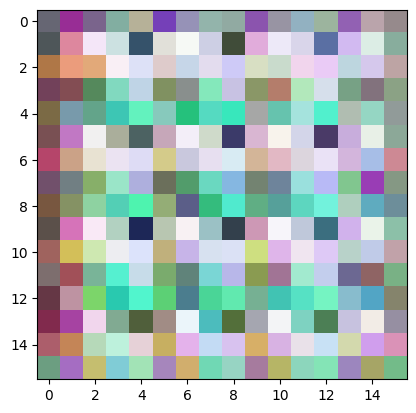

In [20]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 1 noise vector

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

# Resize the generated image
resize_transform = transforms.Resize((16, 16))
resized_fake_images = resize_transform(fake_images)

# Convert to numpy array for visualization
image_noise = resized_fake_images.detach().numpy().reshape((3, 16, 16)) * 0.5 + 0.5

# Display the image
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.show()


<strong> Plotting losses </strong>

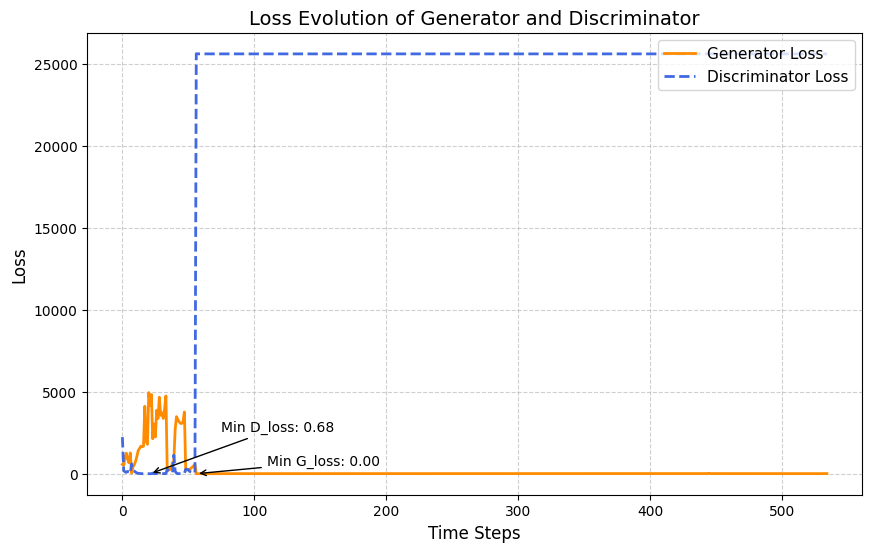

In [21]:
# Assuming G_loss and D_loss are defined
n = len(G_loss)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()


<strong> Plotting FID (Fréchet Inception Distance) values </strong>

Text(0.5, 1.0, 'FID Evolution through training')

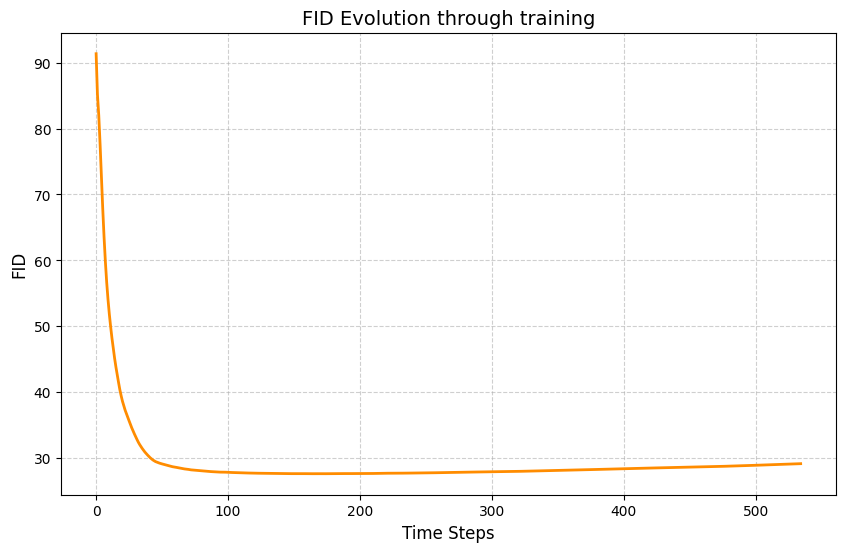

In [23]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)